In [2]:
import torch
from torch_geometric.data import HeteroData
import torch.nn as nn
from torch_geometric.nn import NNConv, global_mean_pool 
import torch.optim as optim
from torch_geometric.nn import GlobalAttention
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
from torch_geometric.loader import DataLoader

In [3]:
import torch

# Load the hetero graph (safe if you trust the source)
data = torch.load("Graph_Results/HeteroGraphs_ScaledFinal/HeteroGraph_T1.pt", weights_only=False)

# Print node types and sizes
print("Node Types and Features:")
for ntype in data.node_types:
    print(f"  {ntype}: {data[ntype].x.shape}")

# Print edge types and count
print("\nEdge Types:")
for etype in data.edge_types:
    edge_index = data[etype].edge_index
    print(f"  {etype}: {edge_index.shape[1]} edges")

# Check a few values from cell node features
print("\nSample cell node features (first 5 rows):")
print(data["cell"].x[:5])


Node Types and Features:
  gene: torch.Size([269, 2])
  cell: torch.Size([1223, 7])
  pathway: torch.Size([808, 2])

Edge Types:
  ('gene', 'involved_in', 'pathway'): 7543 edges
  ('cell', 'expresses', 'gene'): 196479 edges

Sample cell node features (first 5 rows):
tensor([[ 0.6317,  1.1321,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.1880,  1.2070,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5530,  0.0235,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0073,  1.0278,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.3512,  1.3956,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


In [4]:
import torch.nn as nn

class NodeFeatureEncoders(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.cell_encoder = nn.Sequential(
            nn.Linear(7, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.gene_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

    def forward(self, cell_x, gene_x):
        h_cell = self.cell_encoder(cell_x)
        h_gene = self.gene_encoder(gene_x)
        return h_cell, h_gene


In [35]:
class GlobalAttentionWithWeights(GlobalAttention):
    def forward(self, x, index, ptr=None, dim_size=None, dim=0):
        """
        x: Node embeddings
        index: Index tensor (typically the batch vector)
        """
        gate = self.gate_nn(x).squeeze(-1)      # [N]
        gate = torch.sigmoid(gate)              # attention weights
        x_weighted = x * gate.unsqueeze(-1)     # [N, F]

        # Perform aggregation (mean by default)
        out = torch.zeros(dim_size or int(index.max()) + 1, x.size(-1), device=x.device)
        out = out.index_add(dim, index, x_weighted)

        return out, gate

## NO Attention

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv, global_mean_pool
from torch_geometric.utils import to_dense_batch

class SharedHierarchicalEncoder_NoAttention(nn.Module):
    def __init__(self, hidden_dim=64, lstm_hidden_dim=None, num_dosages=9, num_aux_outputs=1,
                 dropout=0.1, use_virtual_node=True):
        super().__init__()
        self.use_virtual_node = use_virtual_node
        self.hidden_dim = hidden_dim             

        # === Node encoders (cell and gene)
        self.node_encoders = NodeFeatureEncoders(hidden_dim)

        # === Edge MLP for cell → gene
        self.edge_mlp_cell_gene = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )

        # === Message Passing (only cell → gene)
        self.cell_to_gene_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_cell_gene, aggr='mean')

        # === Final fusion for graph-level embedding
        self.dropout = nn.Dropout(dropout)
        self.fuse_global = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Optional auxiliary head
        self.aux_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_aux_outputs)
        )

        # === Virtual Node (Dosage-aware)
        if self.use_virtual_node:
            lstm_dim = lstm_hidden_dim or hidden_dim
            self.dosage_embeddings = nn.Embedding(num_dosages, hidden_dim)
            self.virtual_norm = nn.LayerNorm(hidden_dim)
            self.dosage_lstm = nn.LSTM(hidden_dim, lstm_dim, batch_first=True)

            self.fuse_cell_virtual = nn.Sequential(
                nn.Linear(hidden_dim + lstm_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )
            self.fuse_gene_virtual = nn.Sequential(
                nn.Linear(hidden_dim + lstm_dim, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )

    def refine_virtuals_with_lstm(self):
        raw_dosage_embeddings = self.dosage_embeddings.weight.unsqueeze(0)  # [1, num_dosages, H]
        lstm_out, _ = self.dosage_lstm(raw_dosage_embeddings)
        return self.virtual_norm(lstm_out.squeeze(0))  # [num_dosages, H]

    def get_batch_safe(self, node_data, device):
        """Return .batch if available, else dummy zeros"""
        batch = getattr(node_data, "batch", None)
        if batch is None:
            return torch.zeros(node_data.num_nodes, dtype=torch.long, device=device)
        return batch

    def forward(self, data, dosage_idx=None):
        cell_x = data["cell"].x
        gene_x = data["gene"].x
        device = cell_x.device

        # === Node feature encoding
        h_cell, h_gene = self.node_encoders(cell_x, gene_x)

        # === Handle virtual dosage node
        if self.use_virtual_node:
            refined_dosage_virtuals = self.refine_virtuals_with_lstm()
            dosage_virtual = refined_dosage_virtuals[dosage_idx]  # [B, H]

            cell_batch = self.get_batch_safe(data["cell"], device)
            gene_batch = self.get_batch_safe(data["gene"], device)

            h_cell = self.fuse_cell_virtual(torch.cat([h_cell, dosage_virtual[cell_batch]], dim=1))
            h_gene = self.fuse_gene_virtual(torch.cat([h_gene, dosage_virtual[gene_batch]], dim=1))
        else:
            dosage_virtual = torch.zeros(h_cell.size(0), self.hidden_dim, device=h_cell.device)

        # === Message Passing (cell → gene)
        h_gene_updated = self.cell_to_gene_conv(
            (h_cell, h_gene),
            data["cell", "expresses", "gene"].edge_index,
            data["cell", "expresses", "gene"].edge_attr
        )

        # === Graph embedding via global mean pooling over genes
        gene_batch = self.get_batch_safe(data["gene"], device)
        pooled_gene = global_mean_pool(h_gene_updated, gene_batch)

        graph_embedding = self.fuse_global(torch.cat([
            pooled_gene, dosage_virtual
        ], dim=1))

        aux_output = self.aux_head(graph_embedding)

        # === Normalize outputs for cosine comparison
        h_cell = F.normalize(h_cell, p=2, dim=-1)
        h_gene_updated = F.normalize(h_gene_updated, p=2, dim=-1)

        return {
            "h_cell": h_cell,
            "h_gene": h_gene_updated,
            "dosage_virtual": dosage_virtual,
            "graph_embedding": graph_embedding,
            "aux_output": aux_output.squeeze(),
            "gene_attention_weights": None  # <== No attention in this model
        }


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneToCellDecoder_NoAttention(nn.Module):
    def __init__(self, hidden_dim=64, cell_feature_dim=7, dropout=0.1, use_virtual_node=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cell_feature_dim = cell_feature_dim  # ✅ store for later use
        self.use_virtual_node = use_virtual_node

        # === Pool gene embeddings to single graph embedding
        self.gene_pool_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Cell Reconstruction
        self.decode_to_cells_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        self.decode_to_cells_proj = nn.Linear(hidden_dim, cell_feature_dim)  # ✅ used here

        # === Gene Reconstruction
        self.decode_to_genes_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        self.decode_to_genes_proj = nn.Linear(hidden_dim, hidden_dim)

        if self.use_virtual_node:
            self.dosage_embedding = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, h_gene_updated, h_cell, graph_embedding, dosage_virtual=None):
        B, N_cells, _ = h_cell.size()
        _, N_genes, _ = h_gene_updated.size()

        # === Virtual node adjustment
        if self.use_virtual_node and dosage_virtual is not None:
            graph_embedding = graph_embedding + self.dosage_embedding(dosage_virtual)

        # === Pool gene embeddings to graph embedding
        h_gene_pooled = h_gene_updated.mean(dim=1)  # [B, H]
        gene_graph_embedding = self.gene_pool_proj(h_gene_pooled)  # [B, H]

        # === Expand to match number of cells
        gene_to_cell_input = gene_graph_embedding.unsqueeze(1).expand(-1, N_cells, -1)  # [B, N_cells, H]

        # === Decode cells
        cell_recon = gene_to_cell_input + h_cell  # Residual connection
        cell_recon = self.decode_to_cells_fc(cell_recon)
        cell_recon = F.normalize(self.decode_to_cells_proj(cell_recon), p=2, dim=-1)  # ✅ 64-d output

        # === Decode genes
        gene_recon = self.decode_to_genes_fc(h_gene_updated)
        gene_recon = F.normalize(self.decode_to_genes_proj(gene_recon), p=2, dim=-1)

        return {
            "reconstructed_cells": cell_recon,      # ✅ [B, N_cells, 64]
            "reconstructed_genes": gene_recon,      # ✅ [B, N_genes, 64]
            "attention_gene_to_cell": None,
            "attention_entropy": None,
            "attention_kl_div": None
        }


In [26]:
import os
import torch
import torch_geometric
from torch_geometric.data.storage import NodeStorage

# ✅ Whitelist NodeStorage for unpickling in PyTorch ≥ 2.6
torch.serialization.add_safe_globals([NodeStorage])

def load_all_dosage_graphs_for_batching(graph_dir, pattern_prefix="HeteroGraph_T"):
    graphs = []
    dosage_keys = []

    for fname in os.listdir(graph_dir):
        if fname.startswith(pattern_prefix) and fname.endswith(".pt"):
            dosage_key = fname.replace(".pt", "").replace(pattern_prefix, "T")
            path = os.path.join(graph_dir, fname)
            
            # ✅ Explicitly allow full object loading
            data = torch.load(path, weights_only=False)
            
            data.dosage_key = dosage_key  # for reference
            dosage_keys.append(dosage_key)
            graphs.append(data)

    # Sort graphs and dosage keys by numeric dosage (T1, T2.5, ..., T320)
    sorted_pairs = sorted(zip(dosage_keys, graphs), key=lambda x: float(x[0].replace("T", "")))
    sorted_dosage_keys, sorted_graphs = zip(*sorted_pairs)

    # Create dosage index mapping
    dosage_levels = [float(k.replace("T", "")) for k in sorted_dosage_keys]
    dosage_to_idx = {
        f"T{int(d) if d.is_integer() else d}": i for i, d in enumerate(dosage_levels)
    }

    # Add dosage_idx to each graph
    for graph, key in zip(sorted_graphs, sorted_dosage_keys):
        graph.dosage_idx = torch.tensor([dosage_to_idx[key]], dtype=torch.long)

    return list(sorted_graphs), dosage_to_idx


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneToCellLoss_NoAttention(nn.Module):
    def __init__(
        self,
        lambda_cell=1.0,
        lambda_gene=1.0,
        use_stat_alignment=True,
        reduction='mean',
        **kwargs
    ):
        super().__init__()
        self.lambda_cell = lambda_cell
        self.lambda_gene = lambda_gene
        self.use_stat_alignment = use_stat_alignment
        self.reduction = reduction

    def forward(self, recon, target):
        loss_components = {}

        # === Gene Reconstruction Loss
        recon_gene = recon["reconstructed_genes"]
        target_gene = target["h_gene"]

        recon_gene = recon_gene.view(-1, recon_gene.shape[-1])
        target_gene = target_gene.view(-1, target_gene.shape[-1])

        L_gene = F.mse_loss(recon_gene, target_gene, reduction=self.reduction)

        if self.use_stat_alignment:
            std_diff = F.mse_loss(recon_gene.std(dim=0), target_gene.std(dim=0), reduction=self.reduction)
            mean_diff = F.mse_loss(recon_gene.mean(dim=0), target_gene.mean(dim=0), reduction=self.reduction)
            L_gene += std_diff + mean_diff

        loss_components["gene_loss"] = self.lambda_gene * L_gene

        # === Cell Reconstruction Loss
        recon_cell = recon["reconstructed_cells"]
        target_cell = target["h_cell"]

        recon_cell = recon_cell.view(-1, recon_cell.shape[-1])
        target_cell = target_cell.view(-1, target_cell.shape[-1])

        L_cell = F.mse_loss(recon_cell, target_cell, reduction=self.reduction)
        loss_components["cell_loss"] = self.lambda_cell * L_cell

        # === Total Loss
        total = sum(loss_components.values())
        loss_components["total_loss"] = total

        return total, loss_components


In [28]:
def train_gene_to_cell_model_no_attention(
    encoder, decoder, graphs_list, dosage_to_idx,
    optimizer=None,
    device='cuda',
    epochs=100,
    loss_weights=None,
    save_path=None,
    lr=1e-3,
    weight_decay=1e-5,
    patience=30,
    min_delta=1e-3,
    batch_size=2
):
    import os
    import json
    import torch
    from torch_geometric.utils import to_dense_batch
    from torch_geometric.loader import DataLoader
    from torch.optim import Adam
    from torch.optim.lr_scheduler import ReduceLROnPlateau

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    loss_kwargs = {k: v for k, v in (loss_weights or {}).items() if k not in ["log_grad_norm", "monitored_losses"]}
    criterion = GeneToCellLoss_NoAttention(**loss_kwargs).to(device)

    monitored_keys = loss_weights.get("monitored_losses", ["total_loss"]) if loss_weights else ["total_loss"]
    best_monitored_loss = {k: float("inf") for k in monitored_keys} if len(monitored_keys) > 1 else float("inf")

    if optimizer is None:
        optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=weight_decay)

    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True, min_lr=1e-5)
    loader = DataLoader(graphs_list, batch_size=batch_size, shuffle=False)

    loss_log = []
    recon_outputs_log = []
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        epoch_loss_dict = {k: 0.0 for k in ["cell_loss", "gene_loss", "total_loss"]}

        for batch in loader:
            batch = batch.to(device)
            encoder_out = encoder(batch, batch.dosage_idx)

            h_gene, _ = to_dense_batch(encoder_out["h_gene"], batch["gene"].batch)
            h_cell, _ = to_dense_batch(encoder_out["h_cell"], batch["cell"].batch)

            decoder_out = decoder(
                h_gene_updated=h_gene,
                h_cell=h_cell,
                graph_embedding=encoder_out["graph_embedding"],
                dosage_virtual=encoder_out.get("dosage_virtual")
            )

            targets = {
                "h_cell": h_cell.detach(),
                "h_gene": h_gene.detach(),
                "cell_batch": batch["cell"].batch,
                "gene_batch": batch["gene"].batch
            }

            loss, loss_components = criterion(decoder_out, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for key in epoch_loss_dict:
                epoch_loss_dict[key] += loss_components.get(key, 0.0)

            recon_outputs_log.append({
                "dosage_idx": int(batch.dosage_idx.item()),
                "attention": None,
                "reconstructed_cells": decoder_out["reconstructed_cells"].detach().cpu().tolist(),
                "reconstructed_genes": decoder_out["reconstructed_genes"].detach().cpu().tolist(),
                "real_cell_embeddings": h_cell.detach().cpu().tolist(),
                "real_gene_embeddings": h_gene.detach().cpu().tolist()
            })

        num_batches = len(loader)
        avg_loss_dict = {k: v / num_batches for k, v in epoch_loss_dict.items()}
        loss_log.append(avg_loss_dict)

        scheduler_loss = avg_loss_dict["total_loss"]
        scheduler.step(scheduler_loss)

        improvement = False
        for k in monitored_keys:
            current = avg_loss_dict[k]
            if isinstance(best_monitored_loss, dict):
                if current < best_monitored_loss[k] - min_delta:
                    best_monitored_loss[k] = current
                    improvement = True
            else:
                if current < best_monitored_loss - min_delta:
                    best_monitored_loss = current
                    improvement = True

        print("Epoch {:03d} | Total: {:.4f} | Cell: {:.4f}, Gene: {:.4f}".format(
            epoch + 1, avg_loss_dict['total_loss'], avg_loss_dict['cell_loss'], avg_loss_dict['gene_loss']
        ))

        if improvement:
            best_epoch = epoch + 1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping at epoch {} after {} stagnant epochs.".format(epoch + 1, patience))
            break

    # === Save model and logs for best epoch only
    if save_path:
        torch.save({
            "encoder": encoder.state_dict(),
            "decoder": decoder.state_dict()
        }, save_path)
        print("Model saved to {}".format(save_path))

        def tensor_to_python(x):
            if isinstance(x, torch.Tensor):
                return x.item() if x.dim() == 0 else x.detach().cpu().tolist()
            elif isinstance(x, dict):
                return {k: tensor_to_python(v) for k, v in x.items()}
            elif isinstance(x, list):
                return [tensor_to_python(i) for i in x]
            return x

        def save_json(path, obj):
            obj_clean = tensor_to_python(obj)
            with open(path, "w") as f:
                json.dump(obj_clean, f, indent=2)

        loss_log = loss_log[:best_epoch]
        best_recon_outputs = recon_outputs_log[(best_epoch - 1) * len(loader): best_epoch * len(loader)]

        save_json(save_path.replace(".pth", "_loss_log.json"), loss_log)
        save_json(save_path.replace(".pth", "_recon_outputs.json"), best_recon_outputs)

    return encoder, decoder, loss_log, best_epoch


In [30]:
import torch

# === Step 1: Load graphs
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs_list, dosage_to_idx = load_all_dosage_graphs_for_batching(graph_dir)

# === Step 2: Instantiate models (no-attention versions)
hidden_dim = 64
encoder = SharedHierarchicalEncoder_NoAttention(hidden_dim=hidden_dim, num_dosages=len(dosage_to_idx))
decoder = GeneToCellDecoder_NoAttention(hidden_dim=hidden_dim, cell_feature_dim=64)

# === Step 3: Define loss weights (no attention)
loss_weights = {
    "lambda_cell": 1.0,
    "lambda_gene": 1.0,
    "use_stat_alignment": True,
    "monitored_losses": ["total_loss"]
}

# === Step 4: Train using no-attention trainer
trained_encoder, trained_decoder, loss_log, best_epoch = train_gene_to_cell_model_no_attention(
    encoder=encoder,
    decoder=decoder,
    graphs_list=graphs_list,
    dosage_to_idx=dosage_to_idx,
    device='cpu',
    epochs=45,
    save_path="trained_gene_to_cell_model_no_attention.pth",
    loss_weights=loss_weights,
    batch_size=1
)

print(f"\n🎯 Best Epoch: {best_epoch}")


Epoch 001 | Total: 0.0857 | Cell: 0.0289, Gene: 0.0569
Epoch 002 | Total: 0.0520 | Cell: 0.0184, Gene: 0.0336
Epoch 003 | Total: 0.0280 | Cell: 0.0108, Gene: 0.0172
Epoch 004 | Total: 0.0161 | Cell: 0.0067, Gene: 0.0094
Epoch 005 | Total: 0.0101 | Cell: 0.0047, Gene: 0.0055
Epoch 006 | Total: 0.0078 | Cell: 0.0040, Gene: 0.0038
Epoch 007 | Total: 0.0071 | Cell: 0.0039, Gene: 0.0032
Epoch 008 | Total: 0.0070 | Cell: 0.0038, Gene: 0.0032
Epoch 009 | Total: 0.0072 | Cell: 0.0037, Gene: 0.0034
Epoch 010 | Total: 0.0075 | Cell: 0.0037, Gene: 0.0038
Epoch 011 | Total: 0.0079 | Cell: 0.0037, Gene: 0.0042
Epoch 012 | Total: 0.0086 | Cell: 0.0038, Gene: 0.0048
Epoch 013 | Total: 0.0093 | Cell: 0.0039, Gene: 0.0055
Epoch 014 | Total: 0.0099 | Cell: 0.0039, Gene: 0.0060
Epoch 015 | Total: 0.0103 | Cell: 0.0043, Gene: 0.0059
Epoch 016 | Total: 0.0093 | Cell: 0.0036, Gene: 0.0057
Epoch 017 | Total: 0.0093 | Cell: 0.0036, Gene: 0.0058
Epoch 018 | Total: 0.0092 | Cell: 0.0035, Gene: 0.0057
Epoch 019 

In [32]:
import torch
import json
import os

# === Model and file paths
model_path = "trained_gene_to_cell_model_no_attention.pth"
model_prefix = model_path.replace(".pth", "")

# === Architecture config (must match training config exactly!)
hidden_dim = 64
cell_feature_dim = 64       # ✅ FIXED: this matches trained decoder output
dropout = 0.2
use_virtual_node = True

# === Rebuild encoder and decoder (NoAttention versions)
encoder = SharedHierarchicalEncoder_NoAttention(
    hidden_dim=hidden_dim,
    num_dosages=len(dosage_to_idx),
    use_virtual_node=use_virtual_node,
    dropout=dropout
)

decoder = GeneToCellDecoder_NoAttention(
    hidden_dim=hidden_dim,
    cell_feature_dim=cell_feature_dim,  # ✅ Now matches saved model
    dropout=dropout,
    use_virtual_node=use_virtual_node
)

# === Load weights
state_dict = torch.load(model_path, map_location='cpu')
encoder.load_state_dict(state_dict["encoder"])
decoder.load_state_dict(state_dict["decoder"])

# === Set to eval mode
encoder.eval()
decoder.eval()

# === Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

print(f"✅ No-Attention Model successfully loaded and moved to {device}")

# === Optional: Load saved JSON logs (for post hoc analysis)
def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

loss_log_path = model_prefix + "_loss_log.json"
recon_outputs_path = model_prefix + "_recon_outputs.json"

# === Load logs if they exist
if os.path.exists(loss_log_path):
    loss_log = load_json(loss_log_path)
    print(f"📈 Loaded loss log ({len(loss_log)} epochs)")

if os.path.exists(recon_outputs_path):
    recon_outputs = load_json(recon_outputs_path)
    print(f"📊 Loaded {len(recon_outputs)} graph reconstructions")


✅ No-Attention Model successfully loaded and moved to cpu
📈 Loaded loss log (31 epochs)
📊 Loaded 9 graph reconstructions


/home/sachit/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


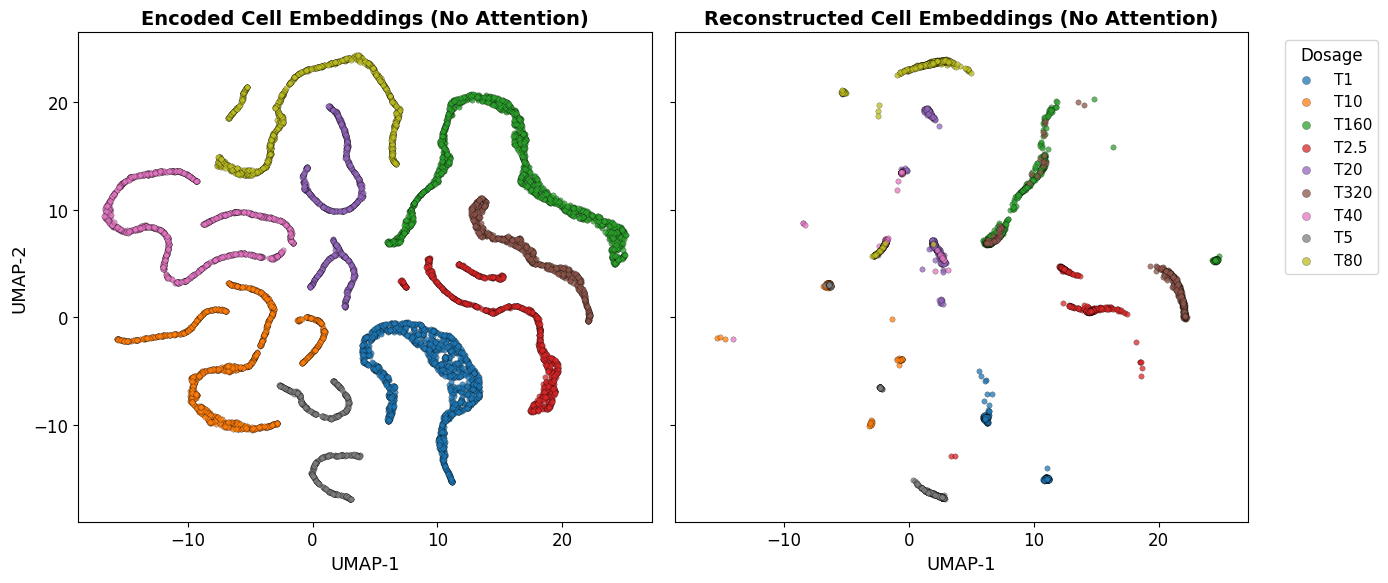

In [33]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib as mpl

# === Step 1: Load recon outputs from no-attention model
with open("trained_gene_to_cell_model_no_attention_recon_outputs.json", "r") as f:
    recon_outputs = json.load(f)

# === Step 2: Dosage label mapping
dosage_to_idx = {
    "T1": 0, "T2.5": 1, "T5": 2, "T10": 3, "T20": 4,
    "T40": 5, "T80": 6, "T160": 7, "T320": 8
}
idx_to_dosage = {v: k for k, v in dosage_to_idx.items()}

# === Step 3: Aggregate real + recon cell embeddings
real_all, recon_all = [], []
real_labels, recon_labels = [], []

for entry in recon_outputs:
    dosage = idx_to_dosage.get(entry["dosage_idx"], f"IDX_{entry['dosage_idx']}")
    real = np.array(entry["real_cell_embeddings"]).squeeze(0)
    recon = np.array(entry["reconstructed_cells"]).squeeze(0)

    if real.shape[1] != recon.shape[1]:
        print(f"⚠️ Skipping {dosage}: real={real.shape}, recon={recon.shape}")
        continue

    real_all.append(real)
    recon_all.append(recon)
    real_labels.extend([dosage] * len(real))
    recon_labels.extend([dosage] * len(recon))

real_all = np.vstack(real_all)
recon_all = np.vstack(recon_all)

# === Check that dimensions match before applying PCA
assert real_all.shape == recon_all.shape, f"Shape mismatch: real {real_all.shape}, recon {recon_all.shape}"

# === Step 4: PCA smoothing
n_features = real_all.shape[1]
pca = PCA(n_components=min(n_features, 7))
real_pca = pca.fit_transform(real_all)
recon_pca = pca.transform(recon_all)

# === Step 5: UMAP (shared init)
# === Step 5: UMAP (fit on real, transform recon)
umap = UMAP(n_neighbors=30, min_dist=0.4, metric='cosine', random_state=42, init="spectral")
real_umap = umap.fit_transform(real_pca)
recon_umap = umap.transform(recon_pca)  # ✅ Ensures shared manifold


# === Optional: Save UMAP embeddings for reproducibility
np.save("umap_real_no_attention.npy", real_umap)
np.save("umap_recon_no_attention.npy", recon_umap)

# === Step 6: Plot config
mpl.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 11
})

dosages = sorted(set(real_labels))
color_map = plt.get_cmap('tab10')
color_dict = {d: color_map(i % 10) for i, d in enumerate(dosages)}

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# === Left: Real (Encoded from Encoder)
for d in dosages:
    idxs = [i for i, l in enumerate(real_labels) if l == d]
    axs[0].scatter(real_umap[idxs, 0], real_umap[idxs, 1],
                   label=d, s=15, alpha=0.75, edgecolor='k', linewidth=0.2,
                   color=color_dict[d])
axs[0].set_title("Encoded Cell Embeddings (No Attention)", weight='bold')
axs[0].set_xlabel("UMAP-1")
axs[0].set_ylabel("UMAP-2")

# === Right: Reconstructed (Decoder Output)
for d in dosages:
    idxs = [i for i, l in enumerate(recon_labels) if l == d]
    axs[1].scatter(recon_umap[idxs, 0], recon_umap[idxs, 1],
                   label=d, s=15, alpha=0.75, edgecolor='k', linewidth=0.2,
                   color=color_dict[d])
axs[1].set_title("Reconstructed Cell Embeddings (No Attention)", weight='bold')
axs[1].set_xlabel("UMAP-1")

# === Legend
axs[1].legend(title="Dosage", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=1.5)
plt.tight_layout()

# === Optional: Save to file
# plt.savefig("umap_real_vs_recon_no_attention.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


In [34]:
import json
import torch
import torch.nn.functional as F
import pandas as pd

# === Step 1: Load recon outputs from no-attention model
with open("trained_gene_to_cell_model_no_attention_recon_outputs.json", "r") as f:
    recon_outputs = json.load(f)

# === Step 2: Dosage ID mapping
dosage_to_idx = {
    "T1": 0, "T2.5": 1, "T5": 2, "T10": 3, "T20": 4,
    "T40": 5, "T80": 6, "T160": 7, "T320": 8
}
idx_to_dosage = {v: k for k, v in dosage_to_idx.items()}

# === Step 3: Compute metrics per dosage
results = []
real_all = []
recon_all = []

for entry in recon_outputs:
    dosage = idx_to_dosage.get(entry["dosage_idx"], "unknown")
    
    real = torch.tensor(entry["real_cell_embeddings"], dtype=torch.float).squeeze(0)
    recon = torch.tensor(entry["reconstructed_cells"], dtype=torch.float).squeeze(0)
    
    if real.shape != recon.shape:
        print(f"⚠️ Skipping {dosage} due to shape mismatch: {real.shape} vs {recon.shape}")
        continue

    # Mean Squared Error
    mse = F.mse_loss(recon, real, reduction='mean').item()

    # Cosine Similarity
    real_norm = F.normalize(real, dim=-1)
    recon_norm = F.normalize(recon, dim=-1)
    cosine_sim = F.cosine_similarity(real_norm, recon_norm, dim=-1).mean().item()

    results.append({
        "Dosage": dosage,
        "MSE": round(mse, 6),
        "CosineSimilarity": round(cosine_sim, 6)
    })

    real_all.append(real)
    recon_all.append(recon)

# === Step 4: Output as DataFrame (sorted)
df_metrics = pd.DataFrame(results)
df_metrics = df_metrics.sort_values(by="Dosage", key=lambda col: [dosage_to_idx.get(d, 999) for d in col])

# === Step 5: Overall metrics
real_all = torch.cat(real_all, dim=0)
recon_all = torch.cat(recon_all, dim=0)

mse_all = F.mse_loss(recon_all, real_all, reduction='mean').item()
cosine_all = F.cosine_similarity(
    F.normalize(recon_all, dim=-1),
    F.normalize(real_all, dim=-1),
    dim=-1
).mean().item()

# Add overall row
df_metrics.loc[len(df_metrics.index)] = {
    "Dosage": "Overall",
    "MSE": round(mse_all, 6),
    "CosineSimilarity": round(cosine_all, 6)
}

# === Print table
print("\n📊 Per-dosage and Overall Reconstruction Metrics:")
print(df_metrics.to_string(index=False))



📊 Per-dosage and Overall Reconstruction Metrics:
 Dosage      MSE  CosineSimilarity
     T1 0.002825          0.909610
   T2.5 0.002482          0.920564
     T5 0.002933          0.906128
    T10 0.002507          0.919782
    T20 0.002602          0.916724
    T40 0.003017          0.903454
    T80 0.003133          0.899748
   T160 0.001843          0.941033
   T320 0.002146          0.931320
Overall 0.002577          0.917529


## NO LSTM

In [43]:
class SharedHierarchicalEncoder_NoLSTM(nn.Module):
    def __init__(self, hidden_dim=64, num_dosages=9, num_aux_outputs=1,
                 dropout=0.1, use_virtual_node=True):
        super().__init__()
        self.use_virtual_node = use_virtual_node
        self.hidden_dim = hidden_dim

        # === Node encoders (cell and gene)
        self.node_encoders = NodeFeatureEncoders(hidden_dim)

        # === Edge MLP for cell → gene
        self.edge_mlp_cell_gene = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )

        # === Message Passing (only cell → gene)
        self.cell_to_gene_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_cell_gene, aggr='mean')

        # === Attention Pooling over genes
        self.att_pool = GlobalAttentionWithWeights(gate_nn=nn.Linear(hidden_dim, 1))

        # === Final fusion for graph-level embedding
        self.dropout = nn.Dropout(dropout)
        self.fuse_global = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Optional auxiliary head
        self.aux_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_aux_outputs)
        )

        # === Virtual Node (Dosage-aware, no LSTM)
        if self.use_virtual_node:
            self.dosage_embeddings = nn.Embedding(num_dosages, hidden_dim)
            self.virtual_norm = nn.LayerNorm(hidden_dim)

            self.fuse_cell_virtual = nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )
            self.fuse_gene_virtual = nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.ReLU(),
                nn.LayerNorm(hidden_dim)
            )

    def get_batch_safe(self, node_data, device):
        batch = getattr(node_data, "batch", None)
        if batch is None:
            return torch.zeros(node_data.num_nodes, dtype=torch.long, device=device)
        return batch

    def forward(self, data, dosage_idx=None):
        cell_x = data["cell"].x
        gene_x = data["gene"].x
        device = cell_x.device

        h_cell, h_gene = self.node_encoders(cell_x, gene_x)

        if self.use_virtual_node and dosage_idx is not None:
            dosage_virtual = self.virtual_norm(self.dosage_embeddings(dosage_idx))
            cell_batch = self.get_batch_safe(data["cell"], device)
            gene_batch = self.get_batch_safe(data["gene"], device)

            h_cell = self.fuse_cell_virtual(torch.cat([h_cell, dosage_virtual[cell_batch]], dim=1))
            h_gene = self.fuse_gene_virtual(torch.cat([h_gene, dosage_virtual[gene_batch]], dim=1))
        else:
            dosage_virtual = torch.zeros(h_cell.size(0), self.hidden_dim, device=device)

        h_gene_updated = self.cell_to_gene_conv(
            (h_cell, h_gene),
            data["cell", "expresses", "gene"].edge_index,
            data["cell", "expresses", "gene"].edge_attr
        )

        gene_batch = self.get_batch_safe(data["gene"], device)
        pooled_gene, gene_attention_weights = self.att_pool(h_gene_updated, gene_batch)

        graph_embedding = self.fuse_global(torch.cat([
            pooled_gene, dosage_virtual[:pooled_gene.size(0)]
        ], dim=1))

        aux_output = self.aux_head(graph_embedding)

        h_cell = F.normalize(h_cell, p=2, dim=-1)
        h_gene_updated = F.normalize(h_gene_updated, p=2, dim=-1)

        return {
            "h_cell": h_cell,
            "h_gene": h_gene_updated,
            "dosage_virtual": dosage_virtual,
            "graph_embedding": graph_embedding,
            "aux_output": aux_output.squeeze(),
            "gene_attention_weights": gene_attention_weights
        }


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneToCellDecoder_NoLSTM(nn.Module):
    def __init__(self, hidden_dim=64, num_heads=2, dropout=0.1, temperature=1.0, use_virtual_node=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.temperature = temperature
        self.use_virtual_node = use_virtual_node

        self.gene_proj_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )
        self.cell_query_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        self.attn_dropout = nn.Dropout(dropout)
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.decode_to_cells_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        self.decode_to_cells_proj = nn.Linear(hidden_dim, hidden_dim)

        self.decode_to_genes_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        self.decode_to_genes_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, h_gene_updated, h_cell, graph_embedding, dosage_virtual=None):
        B, N_cells, _ = h_cell.size()
        _, N_genes, _ = h_gene_updated.size()

        # ✅ Graph embedding already includes dosage effect — no need to reapply
        h_gene = self.gene_proj_head(h_gene_updated)
        h_cell_q = self.cell_query_proj(h_cell)

        h_gene_scaled = h_gene / self.temperature
        cell_recon, attn_weights = self.attn(
            query=h_cell_q,
            key=h_gene_scaled,
            value=h_gene_scaled,
            need_weights=True,
            average_attn_weights=False
        )

        # === Attention diagnostics
        attn_weights = attn_weights / (attn_weights.sum(dim=-1, keepdim=True) + 1e-8)
        attn_probs = attn_weights.clamp(min=1e-6)
        entropy_per_head = (-attn_probs * torch.log(attn_probs)).sum(dim=-1)
        attention_entropy = entropy_per_head.mean()

        uniform_probs = torch.full_like(attn_probs, 1.0 / attn_probs.size(-1))
        attention_kl_div = F.kl_div(attn_probs.log(), uniform_probs, reduction='batchmean')

        # === Final reconstruction
        cell_recon = F.dropout(cell_recon, p=0.1, training=self.training) + h_cell
        cell_recon = self.decode_to_cells_fc(cell_recon)
        cell_recon = F.normalize(self.decode_to_cells_proj(cell_recon), p=2, dim=-1)

        gene_recon = self.decode_to_genes_fc(h_gene)
        gene_recon = F.normalize(self.decode_to_genes_proj(gene_recon), p=2, dim=-1)

        return {
            "reconstructed_cells": cell_recon,
            "reconstructed_genes": gene_recon,
            "attention_gene_to_cell": attn_weights,
            "attention_entropy": attention_entropy,
            "attention_kl_div": attention_kl_div
        }


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneToCellLoss_NoLSTM(nn.Module):
    def __init__(
        self,
        lambda_cell=1.0,
        lambda_gene=1.0,
        lambda_attention=0.1,
        lambda_kl=0.01,
        use_stat_alignment=False,
        reduction='mean',
        attention_reg_type='kl',  # 'kl', 'entropy', 'both'
        **kwargs
    ):
        super().__init__()
        self.lambda_cell = lambda_cell
        self.lambda_gene = lambda_gene
        self.lambda_attention = lambda_attention
        self.lambda_kl = lambda_kl
        self.use_stat_alignment = use_stat_alignment
        self.reduction = reduction
        self.attention_reg_type = attention_reg_type.lower()

    def forward(self, recon, target):
        loss_components = {}

        # === Gene Reconstruction Loss ===
        recon_gene = recon["reconstructed_genes"]
        target_gene = target["h_gene"]

        recon_gene = recon_gene.view(-1, recon_gene.shape[-1])
        target_gene = target_gene.view(-1, target_gene.shape[-1])

        L_gene = F.mse_loss(recon_gene, target_gene, reduction=self.reduction)

        if self.use_stat_alignment:
            std_diff = F.mse_loss(recon_gene.std(dim=0), target_gene.std(dim=0), reduction=self.reduction)
            mean_diff = F.mse_loss(recon_gene.mean(dim=0), target_gene.mean(dim=0), reduction=self.reduction)
            L_gene += std_diff + mean_diff

        loss_components["gene_loss"] = self.lambda_gene * L_gene

        # === Cell Reconstruction Loss ===
        recon_cell = recon["reconstructed_cells"]
        target_cell = target["h_cell"]

        recon_cell = recon_cell.view(-1, recon_cell.shape[-1])
        target_cell = target_cell.view(-1, target_cell.shape[-1])

        L_cell = F.mse_loss(recon_cell, target_cell, reduction=self.reduction)
        loss_components["cell_loss"] = self.lambda_cell * L_cell

        # === Attention Regularization ===
        attn_reg_loss = 0.0

        if self.attention_reg_type in ['entropy', 'both']:
            entropy = recon.get("attention_entropy", None)
            if entropy is not None and torch.is_tensor(entropy):
                attn_reg_loss += -entropy.mean()  # ❗️maximize entropy

        if self.attention_reg_type in ['kl', 'both']:
            kl_div = recon.get("attention_kl_div", None)
            if kl_div is not None and torch.is_tensor(kl_div):
                attn_reg_loss += kl_div

        loss_components["attention_reg_loss"] = self.lambda_attention * attn_reg_loss

        # === Total Loss
        total = (
            loss_components["gene_loss"] +
            loss_components["cell_loss"] +
            loss_components["attention_reg_loss"]
        )
        loss_components["total_loss"] = total

        return total, loss_components


In [47]:
def train_gene_to_cell_model_NoLSTM(
    encoder, decoder, graphs_list, dosage_to_idx,
    optimizer=None,
    device='cuda',
    epochs=100,
    loss_weights=None,
    save_path=None,
    lr=1e-3,
    weight_decay=1e-5,
    patience=30,
    min_delta=1e-3,
    batch_size=2
):
    import os
    import json
    import torch
    from torch_geometric.utils import to_dense_batch
    from torch_geometric.loader import DataLoader
    from torch.optim import Adam
    from torch.optim.lr_scheduler import ReduceLROnPlateau

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    loss_kwargs = {k: v for k, v in (loss_weights or {}).items() if k not in ["log_grad_norm", "monitored_losses"]}
    criterion = GeneToCellLoss(**loss_kwargs).to(device)

    monitored_keys = loss_weights.get("monitored_losses", ["total_loss"]) if loss_weights else ["total_loss"]
    best_monitored_loss = {k: float("inf") for k in monitored_keys} if len(monitored_keys) > 1 else float("inf")

    if optimizer is None:
        optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=weight_decay)

    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True, min_lr=1e-5)
    loader = DataLoader(graphs_list, batch_size=batch_size, shuffle=False)

    loss_log = []
    attention_log = []
    kl_div_log = []
    recon_outputs_log = []
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        epoch_loss_dict = {k: 0.0 for k in ["cell_loss", "gene_loss", "attention_reg_loss", "total_loss"]}
        epoch_attn_entropy = []
        epoch_attn_kl = []

        for batch in loader:
            batch = batch.to(device)
            encoder_out = encoder(batch, batch.dosage_idx)

            h_gene, _ = to_dense_batch(encoder_out["h_gene"], batch["gene"].batch)
            h_cell, _ = to_dense_batch(encoder_out["h_cell"], batch["cell"].batch)

            decoder_out = decoder(
                h_gene_updated=h_gene,
                h_cell=h_cell,
                graph_embedding=encoder_out["graph_embedding"],
                dosage_virtual=encoder_out.get("dosage_virtual")
            )

            # === Target: 64-dim normalized embeddings from encoder
            targets = {
                "h_cell": h_cell.detach(),
                "h_gene": h_gene.detach(),
                "cell_batch": batch["cell"].batch,
                "gene_batch": batch["gene"].batch
            }

            loss, loss_components = criterion(decoder_out, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for key in epoch_loss_dict:
                epoch_loss_dict[key] += loss_components.get(key, 0.0)

            recon_outputs_log.append({
                "dosage_idx": int(batch.dosage_idx.item()),
                "attention": decoder_out.get("attention_gene_to_cell", None).detach().cpu().tolist()
                if decoder_out.get("attention_gene_to_cell") is not None else None,
                "reconstructed_cells": decoder_out["reconstructed_cells"].detach().cpu().tolist(),
                "reconstructed_genes": decoder_out["reconstructed_genes"].detach().cpu().tolist(),
                "real_cell_embeddings": h_cell.detach().cpu().tolist(),
                "real_gene_embeddings": h_gene.detach().cpu().tolist()
            })

            # === Updated: record attention metrics
            entropy = decoder_out.get("attention_entropy", None)
            if entropy is not None and torch.is_tensor(entropy):
                epoch_attn_entropy.append(entropy.detach().cpu())

            kl_div = decoder_out.get("attention_kl_div", None)
            if kl_div is not None and torch.is_tensor(kl_div):
                epoch_attn_kl.append(kl_div.detach().cpu())

        num_batches = len(loader)
        avg_loss_dict = {k: v / num_batches for k, v in epoch_loss_dict.items()}
        loss_log.append(avg_loss_dict)

        mean_entropy = torch.stack(epoch_attn_entropy).mean().item() if epoch_attn_entropy else 0.0
        attention_log.append(mean_entropy)

        mean_kl = torch.stack(epoch_attn_kl).mean().item() if epoch_attn_kl else 0.0
        kl_div_log.append(mean_kl)

        scheduler_loss = avg_loss_dict["total_loss"]
        scheduler.step(scheduler_loss)

        improvement = False
        for k in monitored_keys:
            current = avg_loss_dict[k]
            if isinstance(best_monitored_loss, dict):
                if current < best_monitored_loss[k] - min_delta:
                    best_monitored_loss[k] = current
                    improvement = True
            else:
                if current < best_monitored_loss - min_delta:
                    best_monitored_loss = current
                    improvement = True

        print("Epoch {:03d} | Total: {:.4f} | Cell: {:.4f}, Gene: {:.4f}, AttnReg: {:.4f} | Entropy: {:.4f} | KLDiv: {:.4f}".format(
            epoch + 1, avg_loss_dict['total_loss'], avg_loss_dict['cell_loss'],
            avg_loss_dict['gene_loss'], avg_loss_dict['attention_reg_loss'],
            mean_entropy, mean_kl
        ))

        if improvement:
            best_epoch = epoch + 1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping at epoch {} after {} stagnant epochs.".format(epoch + 1, patience))
            break

    # === Save model + logs at best epoch
    if save_path:
        torch.save({
            "encoder": encoder.state_dict(),
            "decoder": decoder.state_dict()
        }, save_path)
        print("Model saved to {}".format(save_path))

        def tensor_to_python(x):
            if isinstance(x, torch.Tensor):
                return x.item() if x.dim() == 0 else x.detach().cpu().tolist()
            elif isinstance(x, dict):
                return {k: tensor_to_python(v) for k, v in x.items()}
            elif isinstance(x, list):
                return [tensor_to_python(i) for i in x]
            return x

        def save_json(path, obj):
            obj_clean = tensor_to_python(obj)
            with open(path, "w") as f:
                json.dump(obj_clean, f, indent=2)

        loss_log = loss_log[:best_epoch]
        attention_log = attention_log[:best_epoch]
        kl_div_log = kl_div_log[:best_epoch]
        best_recon_outputs = recon_outputs_log[(best_epoch - 1) * len(loader): best_epoch * len(loader)]

        save_json(save_path.replace(".pth", "_loss_log.json"), loss_log)
        save_json(save_path.replace(".pth", "_attn_entropy.json"), attention_log)
        save_json(save_path.replace(".pth", "_attn_kl_div.json"), kl_div_log)
        save_json(save_path.replace(".pth", "_recon_outputs.json"), best_recon_outputs)

    return encoder, decoder, loss_log, best_epoch


In [48]:
import torch

# === Step 1: Load graphs
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs_list, dosage_to_idx = load_all_dosage_graphs_for_batching(graph_dir)

# === Step 2: Instantiate models (NoLSTM encoder and NoLSTM decoder)
hidden_dim = 64

encoder = SharedHierarchicalEncoder_NoLSTM(  # ✅ No LSTM version
    hidden_dim=hidden_dim,
    num_dosages=len(dosage_to_idx),
    use_virtual_node=True,  # ✅ still uses virtual node but with no LSTM
    dropout=0.2
)

decoder = GeneToCellDecoder_NoLSTM(  # ✅ NoLSTM version of decoder
    hidden_dim=hidden_dim,
    num_heads=2,
    dropout=0.2,
    temperature=1.0,
    use_virtual_node=True
)

# === Step 3: Define loss weights
loss_weights = {
    "lambda_cell": 1.0,
    "lambda_gene": 1.0,
    "lambda_attention": 0.05,
    "lambda_kl": 0.01,
    "use_stat_alignment": True,
    "monitored_losses": ["total_loss"]
}

trained_encoder, trained_decoder, loss_log, best_epoch = train_gene_to_cell_model_NoLSTM(
    encoder=encoder,
    decoder=decoder,
    graphs_list=graphs_list,
    dosage_to_idx=dosage_to_idx,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=30,
    save_path="trained_gene_to_cell_model_NoLSTM.pth",  # ✅ updated filename
    loss_weights=loss_weights,
    batch_size=1
)
print(f"\n🎯 Best Epoch: {best_epoch}")


/home/sachit/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Total: 124.9767 | Cell: 0.0307, Gene: 0.0549, AttnReg: 124.8910 | Entropy: 5.4903 | KLDiv: 2497.8206
Epoch 002 | Total: 126.4452 | Cell: 0.0235, Gene: 0.0441, AttnReg: 126.3775 | Entropy: 5.4766 | KLDiv: 2527.5498
Epoch 003 | Total: 124.3727 | Cell: 0.0196, Gene: 0.0313, AttnReg: 124.3218 | Entropy: 5.5011 | KLDiv: 2486.4353
Epoch 004 | Total: 124.1929 | Cell: 0.0161, Gene: 0.0213, AttnReg: 124.1555 | Entropy: 5.5023 | KLDiv: 2483.1099
Epoch 005 | Total: 123.9567 | Cell: 0.0137, Gene: 0.0150, AttnReg: 123.9279 | Entropy: 5.5033 | KLDiv: 2478.5593
Epoch 006 | Total: 123.9171 | Cell: 0.0121, Gene: 0.0115, AttnReg: 123.8935 | Entropy: 5.5035 | KLDiv: 2477.8696
Epoch 007 | Total: 124.3022 | Cell: 0.0110, Gene: 0.0098, AttnReg: 124.2813 | Entropy: 5.5029 | KLDiv: 2485.6262
Epoch 008 | Total: 124.0673 | Cell: 0.0101, Gene: 0.0089, AttnReg: 124.0483 | Entropy: 5.5034 | KLDiv: 2480.9656
Epoch 009 | Total: 124.0378 | Cell: 0.0093, Gene: 0.0084, AttnReg: 124.0201 | Entropy: 5.5032 | 

In [49]:
import torch
import json
import os

# === Define architecture config (must match training)
hidden_dim = 64
num_heads = 2
dropout = 0.2
use_virtual_node = True

# === Dosage mapping (required for instantiating encoder)
# Replace with your actual mapping if not already defined
dosage_to_idx = {
    "T1": 0, "T2.5": 1, "T5": 2, "T10": 3, "T20": 4,
    "T40": 5, "T80": 6, "T160": 7, "T320": 8
}

# === File paths
model_path = "trained_gene_to_cell_model_NoLSTM.pth"  # ✅ Updated
model_prefix = model_path.replace(".pth", "")

# === Instantiate NoLSTM encoder and decoder
encoder = SharedHierarchicalEncoder_NoLSTM(
    hidden_dim=hidden_dim,
    num_dosages=len(dosage_to_idx),
    use_virtual_node=use_virtual_node,
    dropout=dropout
)

decoder = GeneToCellDecoder_NoLSTM(
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    dropout=dropout,
    use_virtual_node=use_virtual_node
)

# === Load model weights
state_dict = torch.load(model_path, map_location='cpu')
encoder.load_state_dict(state_dict["encoder"])
decoder.load_state_dict(state_dict["decoder"])

# === Set to eval mode and move to device
encoder.eval()
decoder.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

print(f"✅ NoLSTM Model successfully loaded and moved to {device}")

# === Optional: Load JSON logs
def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

# === Load training logs (loss, attention, reconstruction)
loss_log_path = model_prefix + "_loss_log.json"
entropy_log_path = model_prefix + "_attn_entropy.json"
kl_div_log_path = model_prefix + "_attn_kl_div.json"
recon_outputs_path = model_prefix + "_recon_outputs.json"

if os.path.exists(loss_log_path):
    loss_log = load_json(loss_log_path)
    print(f"📈 Loaded loss log ({len(loss_log)} epochs)")

if os.path.exists(entropy_log_path):
    attention_entropy_log = load_json(entropy_log_path)
    print(f"🧠 Loaded attention entropy log ({len(attention_entropy_log)} epochs)")

if os.path.exists(kl_div_log_path):
    kl_div_log = load_json(kl_div_log_path)
    print(f"📉 Loaded attention KL divergence log ({len(kl_div_log)} epochs)")

if os.path.exists(recon_outputs_path):
    recon_outputs = load_json(recon_outputs_path)
    print(f"📊 Loaded {len(recon_outputs)} graph reconstructions with attention maps")


✅ NoLSTM Model successfully loaded and moved to cpu
📈 Loaded loss log (14 epochs)
🧠 Loaded attention entropy log (14 epochs)
📉 Loaded attention KL divergence log (14 epochs)
📊 Loaded 9 graph reconstructions with attention maps


/home/sachit/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


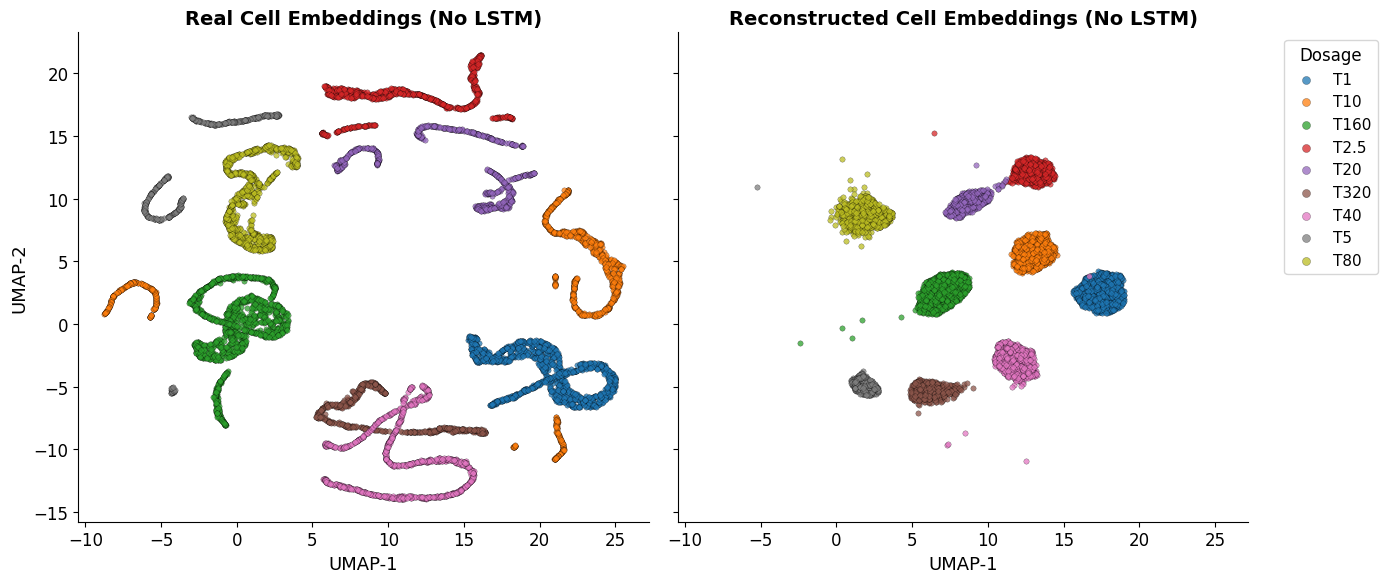

In [50]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib as mpl

# === Step 1: Load recon outputs
with open("trained_gene_to_cell_model_NoLSTM_recon_outputs.json", "r") as f:
    recon_outputs = json.load(f)

# === Step 2: Dosage label mapping
dosage_to_idx = {
    "T1": 0, "T2.5": 1, "T5": 2, "T10": 3, "T20": 4,
    "T40": 5, "T80": 6, "T160": 7, "T320": 8
}
idx_to_dosage = {v: k for k, v in dosage_to_idx.items()}

# === Step 3: Aggregate data
real_all, recon_all = [], []
real_labels, recon_labels = [], []

for entry in recon_outputs:
    dosage = idx_to_dosage.get(entry["dosage_idx"], f"IDX_{entry['dosage_idx']}")
    real = np.array(entry["real_cell_embeddings"]).squeeze(0)
    recon = np.array(entry["reconstructed_cells"]).squeeze(0)

    if real.shape[1] != recon.shape[1]:
        print(f"⚠️ Skipping {dosage}: real={real.shape}, recon={recon.shape}")
        continue

    real_all.append(real)
    recon_all.append(recon)
    real_labels.extend([dosage] * len(real))
    recon_labels.extend([dosage] * len(recon))

real_all = np.vstack(real_all)
recon_all = np.vstack(recon_all)

# === Step 4: Optional L2 normalization
real_all = real_all / (np.linalg.norm(real_all, axis=1, keepdims=True) + 1e-8)
recon_all = recon_all / (np.linalg.norm(recon_all, axis=1, keepdims=True) + 1e-8)

# === Step 5: PCA
n_features = real_all.shape[1]
pca = PCA(n_components=min(n_features, 7))
pca_real = pca.fit_transform(real_all)
pca_recon = pca.transform(recon_all)

# === Step 6: Shared UMAP projection
combined = np.vstack([pca_real, pca_recon])
umap = UMAP(n_neighbors=30, min_dist=0.4, metric='cosine', random_state=42, init="spectral")
combined_umap = umap.fit_transform(combined)
real_umap = combined_umap[:len(pca_real)]
recon_umap = combined_umap[len(pca_real):]

# === Step 7: Plot
mpl.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 11
})

dosages = sorted(set(real_labels))
color_map = plt.get_cmap('tab10')
color_dict = {d: color_map(i % 10) for i, d in enumerate(dosages)}

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# === Plot real embeddings
for d in dosages:
    idxs = [i for i, l in enumerate(real_labels) if l == d]
    axs[0].scatter(real_umap[idxs, 0], real_umap[idxs, 1],
                   label=d, s=15, alpha=0.75, edgecolor='k', linewidth=0.2,
                   color=color_dict[d])
axs[0].set_title("Real Cell Embeddings (No LSTM)", weight='bold')
axs[0].set_xlabel("UMAP-1")
axs[0].set_ylabel("UMAP-2")

# === Plot reconstructed embeddings
for d in dosages:
    idxs = [i for i, l in enumerate(recon_labels) if l == d]
    axs[1].scatter(recon_umap[idxs, 0], recon_umap[idxs, 1],
                   label=d, s=15, alpha=0.75, edgecolor='k', linewidth=0.2,
                   color=color_dict[d])
axs[1].set_title("Reconstructed Cell Embeddings (No LSTM)", weight='bold')
axs[1].set_xlabel("UMAP-1")

# === Shared formatting
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[1].legend(title="Dosage", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=1.5)
plt.tight_layout()
plt.show()


In [52]:
import json
import torch
import torch.nn.functional as F
import pandas as pd

# === Step 1: Load recon outputs for No LSTM model
with open("trained_gene_to_cell_model_NoLSTM_recon_outputs.json", "r") as f:
    recon_outputs = json.load(f)

# === Step 2: Dosage ID mapping
dosage_to_idx = {
    "T1": 0, "T2.5": 1, "T5": 2, "T10": 3, "T20": 4,
    "T40": 5, "T80": 6, "T160": 7, "T320": 8
}
idx_to_dosage = {v: k for k, v in dosage_to_idx.items()}

# === Step 3: Compute metrics per dosage
results = []
all_real = []
all_recon = []

for entry in recon_outputs:
    dosage = idx_to_dosage.get(entry["dosage_idx"], "unknown")
    
    real = torch.tensor(entry["real_cell_embeddings"], dtype=torch.float).squeeze(0)
    recon = torch.tensor(entry["reconstructed_cells"], dtype=torch.float).squeeze(0)
    
    if real.shape != recon.shape:
        print(f"⚠️ Skipping {dosage} due to shape mismatch: {real.shape} vs {recon.shape}")
        continue

    # Store for global metrics
    all_real.append(real)
    all_recon.append(recon)

    # Mean Squared Error
    mse = F.mse_loss(recon, real, reduction='mean').item()

    # Cosine Similarity
    real_norm = F.normalize(real, dim=-1)
    recon_norm = F.normalize(recon, dim=-1)
    cosine_sim = F.cosine_similarity(real_norm, recon_norm, dim=-1).mean().item()

    results.append({
        "Dosage": dosage,
        "MSE": round(mse, 6),
        "CosineSimilarity": round(cosine_sim, 6)
    })

# === Step 4: Global metrics
real_all = torch.cat(all_real, dim=0)
recon_all = torch.cat(all_recon, dim=0)

global_mse = F.mse_loss(recon_all, real_all, reduction='mean').item()
global_cosine = F.cosine_similarity(
    F.normalize(real_all, dim=-1),
    F.normalize(recon_all, dim=-1),
    dim=-1
).mean().item()

# === Step 5: Output as DataFrame
df_metrics = pd.DataFrame(results)
df_metrics = df_metrics.sort_values(by="Dosage", key=lambda col: [dosage_to_idx.get(d, 999) for d in col])

print(df_metrics.to_string(index=False))
print(f"\n📊 Global MSE: {round(global_mse, 6)}")
print(f"📊 Global Cosine Similarity: {round(global_cosine, 6)}")


Dosage      MSE  CosineSimilarity
    T1 0.006917          0.778668
  T2.5 0.005929          0.810264
    T5 0.007649          0.755240
   T10 0.005960          0.809291
   T20 0.007878          0.747910
   T40 0.005293          0.830617
   T80 0.005650          0.819190
  T160 0.007528          0.759112
  T320 0.005360          0.828495

📊 Global MSE: 0.006463
📊 Global Cosine Similarity: 0.793169


## No Virtual Node

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv
from torch_geometric.utils import to_dense_batch

class SharedHierarchicalEncoder_NoVirtualNode(nn.Module):
    def __init__(self, hidden_dim=64, num_aux_outputs=1, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim

        # === Node encoders (cell and gene)
        self.node_encoders = NodeFeatureEncoders(hidden_dim)

        # === Edge MLP for cell → gene
        self.edge_mlp_cell_gene = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * hidden_dim)
        )

        # === Message Passing (only cell → gene)
        self.cell_to_gene_conv = NNConv(hidden_dim, hidden_dim, self.edge_mlp_cell_gene, aggr='mean')

        # === Attention Pooling over genes
        self.att_pool = GlobalAttentionWithWeights(gate_nn=nn.Linear(hidden_dim, 1))

        # === Final fusion for graph-level embedding
        self.dropout = nn.Dropout(dropout)
        self.fuse_global = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),  # Only pooled_gene now
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # === Optional auxiliary head
        self.aux_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_aux_outputs)
        )

    def get_batch_safe(self, node_data, device):
        batch = getattr(node_data, "batch", None)
        if batch is None:
            return torch.zeros(node_data.num_nodes, dtype=torch.long, device=device)
        return batch

    def forward(self, data):
        cell_x = data["cell"].x
        gene_x = data["gene"].x
        device = cell_x.device

        # === Node feature encoding
        h_cell, h_gene = self.node_encoders(cell_x, gene_x)

        # === Message Passing (cell → gene)
        h_gene_updated = self.cell_to_gene_conv(
            (h_cell, h_gene),
            data["cell", "expresses", "gene"].edge_index,
            data["cell", "expresses", "gene"].edge_attr
        )

        # === Graph embedding via gene attention pooling
        gene_batch = self.get_batch_safe(data["gene"], device)
        pooled_gene, gene_attention_weights = self.att_pool(h_gene_updated, gene_batch)

        # === Final fusion (no dosage virtual)
        graph_embedding = self.fuse_global(pooled_gene)

        # === Auxiliary output
        aux_output = self.aux_head(graph_embedding)

        # === Normalize outputs for cosine comparison
        h_cell = F.normalize(h_cell, p=2, dim=-1)
        h_gene_updated = F.normalize(h_gene_updated, p=2, dim=-1)

        return {
            "h_cell": h_cell,
            "h_gene": h_gene_updated,
            "graph_embedding": graph_embedding,
            "aux_output": aux_output.squeeze(),
            "gene_attention_weights": gene_attention_weights
        }


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneToCellDecoder_NoVirtualNode(nn.Module):
    def __init__(self, hidden_dim=64, num_heads=2, dropout=0.1, temperature=1.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.temperature = temperature

        self.gene_proj_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )
        self.cell_query_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        self.attn_dropout = nn.Dropout(dropout)
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.decode_to_cells_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        self.decode_to_cells_proj = nn.Linear(hidden_dim, hidden_dim)

        self.decode_to_genes_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        self.decode_to_genes_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, h_gene_updated, h_cell, graph_embedding):
        B, N_cells, _ = h_cell.size()
        _, N_genes, _ = h_gene_updated.size()

        h_gene = self.gene_proj_head(h_gene_updated)
        h_cell_q = self.cell_query_proj(h_cell)

        h_gene_scaled = h_gene / self.temperature
        cell_recon, attn_weights = self.attn(
            query=h_cell_q,
            key=h_gene_scaled,
            value=h_gene_scaled,
            need_weights=True,
            average_attn_weights=False
        )

        attn_weights = attn_weights / (attn_weights.sum(dim=-1, keepdim=True) + 1e-8)
        attn_probs = attn_weights.clamp(min=1e-6)
        entropy_per_head = (-attn_probs * torch.log(attn_probs)).sum(dim=-1)
        attention_entropy = entropy_per_head.mean()

        uniform_probs = torch.full_like(attn_probs, 1.0 / attn_probs.size(-1))
        attention_kl_div = F.kl_div(attn_probs.log(), uniform_probs, reduction='batchmean')

        cell_recon = F.dropout(cell_recon, p=0.1, training=self.training) + h_cell
        cell_recon = self.decode_to_cells_fc(cell_recon)
        cell_recon = F.normalize(self.decode_to_cells_proj(cell_recon), p=2, dim=-1)

        gene_recon = self.decode_to_genes_fc(h_gene)
        gene_recon = F.normalize(self.decode_to_genes_proj(gene_recon), p=2, dim=-1)

        return {
            "reconstructed_cells": cell_recon,
            "reconstructed_genes": gene_recon,
            "attention_gene_to_cell": attn_weights,
            "attention_entropy": attention_entropy,
            "attention_kl_div": attention_kl_div
        }


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneToCellLoss_NoVirtualNode(nn.Module):
    def __init__(
        self,
        lambda_cell=1.0,
        lambda_gene=1.0,
        lambda_attention=0.1,
        lambda_kl=0.01,
        use_stat_alignment=False,
        reduction='mean',
        attention_reg_type='kl',  # 'kl', 'entropy', 'both'
        **kwargs
    ):
        super().__init__()
        self.lambda_cell = lambda_cell
        self.lambda_gene = lambda_gene
        self.lambda_attention = lambda_attention
        self.lambda_kl = lambda_kl
        self.use_stat_alignment = use_stat_alignment
        self.reduction = reduction
        self.attention_reg_type = attention_reg_type.lower()

    def forward(self, recon, target):
        loss_components = {}

        # === Gene Reconstruction Loss ===
        recon_gene = recon["reconstructed_genes"].view(-1, recon["reconstructed_genes"].shape[-1])
        target_gene = target["h_gene"].view(-1, target["h_gene"].shape[-1])

        L_gene = F.mse_loss(recon_gene, target_gene, reduction=self.reduction)

        if self.use_stat_alignment:
            std_diff = F.mse_loss(recon_gene.std(dim=0), target_gene.std(dim=0), reduction=self.reduction)
            mean_diff = F.mse_loss(recon_gene.mean(dim=0), target_gene.mean(dim=0), reduction=self.reduction)
            L_gene += std_diff + mean_diff

        loss_components["gene_loss"] = self.lambda_gene * L_gene

        # === Cell Reconstruction Loss ===
        recon_cell = recon["reconstructed_cells"].view(-1, recon["reconstructed_cells"].shape[-1])
        target_cell = target["h_cell"].view(-1, target["h_cell"].shape[-1])

        L_cell = F.mse_loss(recon_cell, target_cell, reduction=self.reduction)
        loss_components["cell_loss"] = self.lambda_cell * L_cell

        # === Attention Regularization ===
        attn_reg_loss = 0.0
        if self.attention_reg_type in ['entropy', 'both']:
            entropy = recon.get("attention_entropy", None)
            if isinstance(entropy, torch.Tensor):
                attn_reg_loss += -entropy.mean()  # Maximize entropy

        if self.attention_reg_type in ['kl', 'both']:
            kl_div = recon.get("attention_kl_div", None)
            if isinstance(kl_div, torch.Tensor):
                attn_reg_loss += kl_div

        loss_components["attention_reg_loss"] = self.lambda_attention * attn_reg_loss

        # === Total Loss ===
        total = (
            loss_components["gene_loss"] +
            loss_components["cell_loss"] +
            loss_components["attention_reg_loss"]
        )
        loss_components["total_loss"] = total

        return total, loss_components


In [66]:
def train_gene_to_cell_model_no_virtual(
    encoder, decoder, graphs_list,
    optimizer=None,
    device='cuda',
    epochs=100,
    loss_weights=None,
    save_path=None,
    lr=1e-3,
    weight_decay=1e-5,
    patience=30,
    min_delta=1e-3,
    batch_size=2
):
    import os
    import json
    import torch
    from torch_geometric.utils import to_dense_batch
    from torch_geometric.loader import DataLoader
    from torch.optim import Adam
    from torch.optim.lr_scheduler import ReduceLROnPlateau

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    loss_kwargs = {k: v for k, v in (loss_weights or {}).items() if k not in ["log_grad_norm", "monitored_losses"]}
    criterion = GeneToCellLoss_NoVirtualNode(**loss_kwargs).to(device)

    monitored_keys = loss_weights.get("monitored_losses", ["total_loss"]) if loss_weights else ["total_loss"]
    best_monitored_loss = {k: float("inf") for k in monitored_keys} if len(monitored_keys) > 1 else float("inf")

    if optimizer is None:
        optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=weight_decay)

    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True, min_lr=1e-5)
    loader = DataLoader(graphs_list, batch_size=batch_size, shuffle=False)

    loss_log = []
    attention_log = []
    kl_div_log = []
    recon_outputs_log = []
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        epoch_loss_dict = {k: 0.0 for k in ["cell_loss", "gene_loss", "attention_reg_loss", "total_loss"]}
        epoch_attn_entropy = []
        epoch_attn_kl = []

        for batch in loader:
            batch = batch.to(device)
            encoder_out = encoder(batch)

            h_gene, _ = to_dense_batch(encoder_out["h_gene"], batch["gene"].batch)
            h_cell, _ = to_dense_batch(encoder_out["h_cell"], batch["cell"].batch)

            decoder_out = decoder(
                h_gene_updated=h_gene,
                h_cell=h_cell,
                graph_embedding=encoder_out["graph_embedding"]
            )

            targets = {
                "h_cell": h_cell.detach(),
                "h_gene": h_gene.detach(),
                "cell_batch": batch["cell"].batch,
                "gene_batch": batch["gene"].batch
            }

            loss, loss_components = criterion(decoder_out, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for key in epoch_loss_dict:
                epoch_loss_dict[key] += loss_components.get(key, 0.0)

            # Inside training loop:
            dosage_idx = batch.dosage_idx.item() if hasattr(batch, "dosage_idx") else -1
            
            recon_outputs_log.append({
                "dosage_idx": dosage_idx,
                "attention": decoder_out.get("attention_gene_to_cell", None).detach().cpu().tolist()
                if decoder_out.get("attention_gene_to_cell") is not None else None,
                "reconstructed_cells": decoder_out["reconstructed_cells"].detach().cpu().tolist(),
                "reconstructed_genes": decoder_out["reconstructed_genes"].detach().cpu().tolist(),
                "real_cell_embeddings": h_cell.detach().cpu().tolist(),
                "real_gene_embeddings": h_gene.detach().cpu().tolist()
            })


            entropy = decoder_out.get("attention_entropy", None)
            if entropy is not None and torch.is_tensor(entropy):
                epoch_attn_entropy.append(entropy.detach().cpu())

            kl_div = decoder_out.get("attention_kl_div", None)
            if kl_div is not None and torch.is_tensor(kl_div):
                epoch_attn_kl.append(kl_div.detach().cpu())

        num_batches = len(loader)
        avg_loss_dict = {k: v / num_batches for k, v in epoch_loss_dict.items()}
        loss_log.append(avg_loss_dict)

        mean_entropy = torch.stack(epoch_attn_entropy).mean().item() if epoch_attn_entropy else 0.0
        attention_log.append(mean_entropy)

        mean_kl = torch.stack(epoch_attn_kl).mean().item() if epoch_attn_kl else 0.0
        kl_div_log.append(mean_kl)

        scheduler_loss = avg_loss_dict["total_loss"]
        scheduler.step(scheduler_loss)

        improvement = False
        for k in monitored_keys:
            current = avg_loss_dict[k]
            if isinstance(best_monitored_loss, dict):
                if current < best_monitored_loss[k] - min_delta:
                    best_monitored_loss[k] = current
                    improvement = True
            else:
                if current < best_monitored_loss - min_delta:
                    best_monitored_loss = current
                    improvement = True

        print("Epoch {:03d} | Total: {:.4f} | Cell: {:.4f}, Gene: {:.4f}, AttnReg: {:.4f} | Entropy: {:.4f} | KLDiv: {:.4f}".format(
            epoch + 1, avg_loss_dict['total_loss'], avg_loss_dict['cell_loss'],
            avg_loss_dict['gene_loss'], avg_loss_dict['attention_reg_loss'],
            mean_entropy, mean_kl
        ))

        if improvement:
            best_epoch = epoch + 1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping at epoch {} after {} stagnant epochs.".format(epoch + 1, patience))
            break

    # === Save model + logs at best epoch
    if save_path:
        torch.save({
            "encoder": encoder.state_dict(),
            "decoder": decoder.state_dict()
        }, save_path)
        print("Model saved to {}".format(save_path))

        def tensor_to_python(x):
            if isinstance(x, torch.Tensor):
                return x.item() if x.dim() == 0 else x.detach().cpu().tolist()
            elif isinstance(x, dict):
                return {k: tensor_to_python(v) for k, v in x.items()}
            elif isinstance(x, list):
                return [tensor_to_python(i) for i in x]
            return x

        def save_json(path, obj):
            obj_clean = tensor_to_python(obj)
            with open(path, "w") as f:
                json.dump(obj_clean, f, indent=2)

        loss_log = loss_log[:best_epoch]
        attention_log = attention_log[:best_epoch]
        kl_div_log = kl_div_log[:best_epoch]
        best_recon_outputs = recon_outputs_log[(best_epoch - 1) * len(loader): best_epoch * len(loader)]

        save_json(save_path.replace(".pth", "_loss_log.json"), loss_log)
        save_json(save_path.replace(".pth", "_attn_entropy.json"), attention_log)
        save_json(save_path.replace(".pth", "_attn_kl_div.json"), kl_div_log)
        save_json(save_path.replace(".pth", "_recon_outputs.json"), best_recon_outputs)

    return encoder, decoder, loss_log, best_epoch


In [67]:
import torch

# === Step 1: Load graphs
graph_dir = "Graph_Results/HeteroGraphs_ScaledFinal"
graphs_list, _ = load_all_dosage_graphs_for_batching(graph_dir)  # ✅ dosage_to_idx no longer needed

# === Step 2: Instantiate models
hidden_dim = 64
encoder = SharedHierarchicalEncoder_NoVirtualNode(hidden_dim=hidden_dim)

decoder = GeneToCellDecoder_NoVirtualNode(hidden_dim=hidden_dim)

# === Step 3: Define loss weights
loss_weights = {
    "lambda_cell": 1.0,
    "lambda_gene": 1.0,
    "lambda_attention": 0.05,
    "lambda_kl": 0.01,
    "use_stat_alignment": True,
    "monitored_losses": ["total_loss"]
}

# === Step 4: Train
trained_encoder, trained_decoder, loss_log, best_epoch = train_gene_to_cell_model_no_virtual(
    encoder=encoder,
    decoder=decoder,
    graphs_list=graphs_list,
    device='cpu',
    epochs=30,
    save_path="trained_gene_to_cell_model_novirtual.pth",
    loss_weights=loss_weights,
    batch_size=1
)

print(f"\n🎯 Best Epoch: {best_epoch}")


/home/sachit/.local/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
/home/sachit/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Total: 62.4168 | Cell: 0.0181, Gene: 0.0374, AttnReg: 62.3613 | Entropy: 5.6086 | KLDiv: 1247.2268
Epoch 002 | Total: 61.8481 | Cell: 0.0111, Gene: 0.0114, AttnReg: 61.8256 | Entropy: 5.6196 | KLDiv: 1236.5120
Epoch 003 | Total: 61.6321 | Cell: 0.0089, Gene: 0.0044, AttnReg: 61.6187 | Entropy: 5.6206 | KLDiv: 1232.3741
Epoch 004 | Total: 61.6156 | Cell: 0.0080, Gene: 0.0023, AttnReg: 61.6053 | Entropy: 5.6207 | KLDiv: 1232.1069
Epoch 005 | Total: 61.5242 | Cell: 0.0076, Gene: 0.0017, AttnReg: 61.5149 | Entropy: 5.6208 | KLDiv: 1230.2981
Epoch 006 | Total: 61.5329 | Cell: 0.0073, Gene: 0.0015, AttnReg: 61.5240 | Entropy: 5.6208 | KLDiv: 1230.4806
Epoch 007 | Total: 61.6135 | Cell: 0.0069, Gene: 0.0014, AttnReg: 61.6052 | Entropy: 5.6207 | KLDiv: 1232.1035
Epoch 008 | Total: 61.5108 | Cell: 0.0064, Gene: 0.0013, AttnReg: 61.5031 | Entropy: 5.6209 | KLDiv: 1230.0610
Epoch 009 | Total: 61.5831 | Cell: 0.0057, Gene: 0.0013, AttnReg: 61.5761 | Entropy: 5.6208 | KLDiv: 1231.5229
E

In [68]:
import torch
import json
import os

# === Model and file paths
model_path = "trained_gene_to_cell_model_novirtual.pth"
model_prefix = model_path.replace(".pth", "")

# === Architecture config (must match training)
hidden_dim = 64
num_heads = 2
dropout = 0.2

# === Instantiate models
encoder = SharedHierarchicalEncoder_NoVirtualNode(
    hidden_dim=hidden_dim,
    dropout=dropout
)

decoder = GeneToCellDecoder_NoVirtualNode(
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    dropout=dropout
)

# === Load weights
state_dict = torch.load(model_path, map_location='cpu')
encoder.load_state_dict(state_dict["encoder"])
decoder.load_state_dict(state_dict["decoder"])

# === Set to eval mode and move to device
encoder.eval()
decoder.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

print(f"✅ Model successfully loaded and moved to {device}")

# === Optional: Load saved JSON logs
def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

# === File paths
loss_log_path = model_prefix + "_loss_log.json"
entropy_log_path = model_prefix + "_attn_entropy.json"
kl_div_log_path = model_prefix + "_attn_kl_div.json"
recon_outputs_path = model_prefix + "_recon_outputs.json"

# === Load logs
if os.path.exists(loss_log_path):
    loss_log = load_json(loss_log_path)
    print(f"📈 Loaded loss log ({len(loss_log)} epochs)")

if os.path.exists(entropy_log_path):
    attention_entropy_log = load_json(entropy_log_path)
    print(f"🧠 Loaded attention entropy log ({len(attention_entropy_log)} epochs)")

if os.path.exists(kl_div_log_path):
    kl_div_log = load_json(kl_div_log_path)
    print(f"📉 Loaded attention KL divergence log ({len(kl_div_log)} epochs)")

if os.path.exists(recon_outputs_path):
    recon_outputs = load_json(recon_outputs_path)
    print(f"📊 Loaded {len(recon_outputs)} graph reconstructions with attention maps")


✅ Model successfully loaded and moved to cpu
📈 Loaded loss log (18 epochs)
🧠 Loaded attention entropy log (18 epochs)
📉 Loaded attention KL divergence log (18 epochs)
📊 Loaded 9 graph reconstructions with attention maps


In [ ]:
with open("trained_gene_to_cell_model_novirtual_recon_outputs.json", "r") as f:

/home/sachit/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


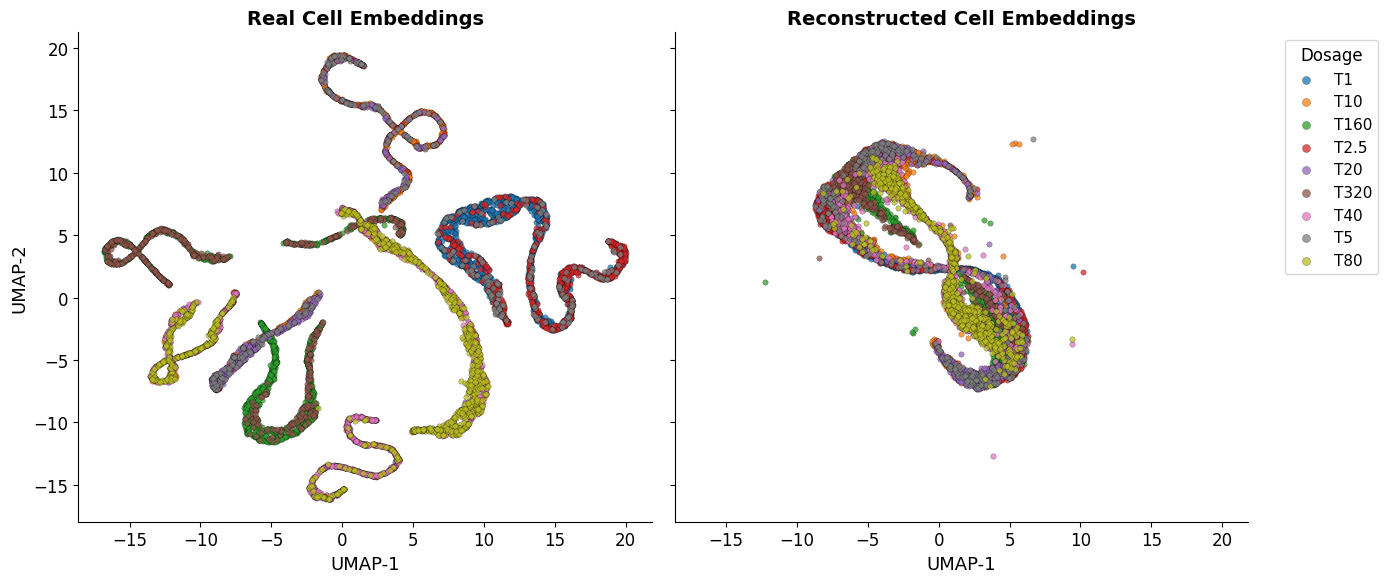

In [69]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib as mpl

# === Step 1: Load recon outputs
with open("trained_gene_to_cell_model_novirtual_recon_outputs.json", "r") as f:
    recon_outputs = json.load(f)

# === Step 2: Dosage label mapping
dosage_to_idx = {
    "T1": 0, "T2.5": 1, "T5": 2, "T10": 3, "T20": 4,
    "T40": 5, "T80": 6, "T160": 7, "T320": 8
}
idx_to_dosage = {v: k for k, v in dosage_to_idx.items()}

# === Step 3: Aggregate data
real_all, recon_all = [], []
real_labels, recon_labels = [], []

for entry in recon_outputs:
    dosage = idx_to_dosage.get(entry["dosage_idx"], f"IDX_{entry['dosage_idx']}")
    real = np.array(entry["real_cell_embeddings"]).squeeze(0)
    recon = np.array(entry["reconstructed_cells"]).squeeze(0)

    if real.shape[1] != recon.shape[1]:
        print(f"⚠️ Skipping {dosage}: real={real.shape}, recon={recon.shape}")
        continue

    real_all.append(real)
    recon_all.append(recon)
    real_labels.extend([dosage] * len(real))
    recon_labels.extend([dosage] * len(recon))

real_all = np.vstack(real_all)
recon_all = np.vstack(recon_all)

# === Step 4: Optional L2 normalization (if not already normalized)
real_all = real_all / (np.linalg.norm(real_all, axis=1, keepdims=True) + 1e-8)
recon_all = recon_all / (np.linalg.norm(recon_all, axis=1, keepdims=True) + 1e-8)

# === Step 5: PCA
n_features = real_all.shape[1]
pca = PCA(n_components=min(n_features, 7))
pca_real = pca.fit_transform(real_all)
pca_recon = pca.transform(recon_all)

# === Step 6: Shared UMAP projection
combined = np.vstack([pca_real, pca_recon])
umap = UMAP(n_neighbors=30, min_dist=0.4, metric='cosine', random_state=42, init="spectral")
combined_umap = umap.fit_transform(combined)
real_umap = combined_umap[:len(pca_real)]
recon_umap = combined_umap[len(pca_real):]

# === Step 7: Plot
mpl.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 11
})

dosages = sorted(set(real_labels))
color_map = plt.get_cmap('tab10')
color_dict = {d: color_map(i % 10) for i, d in enumerate(dosages)}

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# === Plot real embeddings
for d in dosages:
    idxs = [i for i, l in enumerate(real_labels) if l == d]
    axs[0].scatter(real_umap[idxs, 0], real_umap[idxs, 1],
                   label=d, s=15, alpha=0.75, edgecolor='k', linewidth=0.2,
                   color=color_dict[d])
axs[0].set_title("Real Cell Embeddings", weight='bold')
axs[0].set_xlabel("UMAP-1")
axs[0].set_ylabel("UMAP-2")

# === Plot reconstructed embeddings
for d in dosages:
    idxs = [i for i, l in enumerate(recon_labels) if l == d]
    axs[1].scatter(recon_umap[idxs, 0], recon_umap[idxs, 1],
                   label=d, s=15, alpha=0.75, edgecolor='k', linewidth=0.2,
                   color=color_dict[d])
axs[1].set_title("Reconstructed Cell Embeddings", weight='bold')
axs[1].set_xlabel("UMAP-1")

# === Shared formatting
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[1].legend(title="Dosage", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=1.5)
plt.tight_layout()
# plt.savefig("umap_real_vs_recon.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [70]:
import json
import torch
import torch.nn.functional as F
import pandas as pd

# === Step 1: Load recon outputs
with open("trained_gene_to_cell_model_novirtual_recon_outputs.json", "r") as f:
    recon_outputs = json.load(f)

# === Step 2: Dosage ID mapping
dosage_to_idx = {
    "T1": 0, "T2.5": 1, "T5": 2, "T10": 3, "T20": 4,
    "T40": 5, "T80": 6, "T160": 7, "T320": 8
}
idx_to_dosage = {v: k for k, v in dosage_to_idx.items()}

# === Step 3: Compute metrics per dosage
results = []
all_mse, all_cos = [], []

for entry in recon_outputs:
    dosage = idx_to_dosage.get(entry["dosage_idx"], "unknown")
    
    real = torch.tensor(entry["real_cell_embeddings"], dtype=torch.float).squeeze(0)
    recon = torch.tensor(entry["reconstructed_cells"], dtype=torch.float).squeeze(0)
    
    if real.shape != recon.shape:
        print(f"⚠️ Skipping {dosage} due to shape mismatch: {real.shape} vs {recon.shape}")
        continue

    # Mean Squared Error
    mse = F.mse_loss(recon, real, reduction='mean').item()

    # Cosine Similarity
    real_norm = F.normalize(real, dim=-1)
    recon_norm = F.normalize(recon, dim=-1)
    cosine_sim = F.cosine_similarity(real_norm, recon_norm, dim=-1).mean().item()

    results.append({
        "Dosage": dosage,
        "MSE": round(mse, 6),
        "CosineSimilarity": round(cosine_sim, 6)
    })

    all_mse.append(mse)
    all_cos.append(cosine_sim)

# === Step 4: Format output
df_metrics = pd.DataFrame(results)
df_metrics = df_metrics.sort_values(by="Dosage", key=lambda col: [dosage_to_idx.get(d, 999) for d in col])

# === Step 5: Add average row
average_row = pd.DataFrame([{
    "Dosage": "Average",
    "MSE": round(sum(all_mse) / len(all_mse), 6),
    "CosineSimilarity": round(sum(all_cos) / len(all_cos), 6)
}])

df_metrics = pd.concat([df_metrics, average_row], ignore_index=True)

# === Display result
print(df_metrics.to_string(index=False))


 Dosage      MSE  CosineSimilarity
     T1 0.002387          0.923605
   T2.5 0.002118          0.932228
     T5 0.002627          0.915923
    T10 0.003269          0.895404
    T20 0.003264          0.895544
    T40 0.002809          0.910115
    T80 0.002577          0.917524
   T160 0.002634          0.915720
   T320 0.002240          0.928322
Average 0.002658          0.914932
